### Assignment 4

Students: Daniel van de Pavert, Marcel van Lagemaat <br />
ID: 11045418, 10886699

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import pandas as pd
import json

import sys
import os, uuid

import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option("display.max_colwidth", 10000)
# sudo systemctl start elasticsearch.service

In [2]:
INDEX="dataframe"
TYPE= "card"
HOST = 'http://localhost:9200/'
es = Elasticsearch(hosts=[HOST])

### Get and proces the JSON

In [3]:
AllSets = pd.read_json (r'AllSets.json')

In [4]:
AllCardsGRN = pd.DataFrame(AllSets['GRN']['cards'])
AllCardsRNA = pd.DataFrame(AllSets['RNA']['cards'])
AllCardsWAR = pd.DataFrame(AllSets['WAR']['cards'])
AllCardsDOM = pd.DataFrame(AllSets['DOM']['cards'])
AllCardsRIX = pd.DataFrame(AllSets['RIX']['cards'])
AllCardsXLN = pd.DataFrame(AllSets['XLN']['cards'])

DirtySets = [AllCardsGRN, AllCardsRNA, AllCardsWAR, AllCardsDOM, AllCardsRIX, AllCardsXLN]

In [5]:
CleanSets = []
DelColumns = ['edhrecRank', 'foreignData', 'scryfallOracleId', 'leadershipSkills', 'purchaseUrls', 'uuid', 
              'frameEffect', 'frameVersion', 'hasFoil', 'hasNonFoil', 'scryfallId', 'scryfallIllustrationId', 
              'tcgplayerProductId','isArena', 'isMtgo', 'isPaper', 'rulings', 'isReprint', 
              'isStarter', 'isStorySpotlight','prices', 'mcmId', 'mcmMetaId', 'mtgArenaId', 
              'mtgoId', 'mtgstocksId', 'names', 'layout', 'originalText', 'originalType']

for SetCards in DirtySets:
    SetCards = SetCards.T
    for col in DelColumns:
        SetCards = SetCards.drop(col)
        
    SetCards = SetCards.replace(np.nan, '', regex=True)
    print(len(SetCards.T))
    CleanSets.append(SetCards.T)

283
283
311
280
212
299


### Create the elastic indice and fill it

In [6]:
indices = ['grn', 'rva', 'war', 'dom', 'rix', 'xln','set']

for index in indices:
    es.indices.delete(index=index, ignore=[400, 404])
    es.indices.create(index)
    print("Created: " + index + " index")

Created: grn index
Created: rva index
Created: war index
Created: dom index
Created: rix index
Created: xln index
Created: set index


In [7]:
def fillElastic():
    k = 0
    for j in range(len(indices)-1):
        i = 0
        for index, row in CleanSets[j].iterrows():
            gathererID = str(row['multiverseId']).split('.')[0]
            card = {
                'name' : row['name'],
                'colorIdentity' : row['colorIdentity'],
                'convertedManaCost' : row['convertedManaCost'],
                'manaCost' : str(row['manaCost']),
                'text' : row['text'],
                'types' : row['types'],
                'set' : indices[j],
                'url' : 'https://gatherer.wizards.com/Pages/Card/Details.aspx?multiverseid=' + gathererID
            }
            es.index(index=indices[j], doc_type=TYPE, id=i, body=card)
            es.index(index=indices[len(indices)-1], doc_type=TYPE, id=k, body=card)
            k+= 1
            i+= 1
        print("Size " + indices[j] + " index: " + str(es.count(index=indices[j])['count'])) 
        
fillElastic()

Size grn index: 281
Size rva index: 278
Size war index: 305
Size dom index: 277
Size rix index: 210
Size xln index: 297


### Simple search
Below this cell you can enter a query for basic search. An example query is in this case 'draw and deathtouch', where you would want to know what cards have the effect that you can draw another card and that the creature has the keyword deathtouch. 

In [19]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

def text_search_helper(query, index, size):
    if len(query) > 1:
        t = "best_fields"
    else:
        t = "most_fields"
        
    q = {
      "query": {
        "multi_match" : {
          "query": query, 
          "type" : t,
          "fields": [ "name", "text" ] 
        }
      }
    }
    
    res = es.search(index = index, body = q, size = size)
    
    return res['hits']['hits']

def plot_results(df):
    plt.figure()
    df['convertedManaCost'].hist()


@interact
def simple_search(query = "", index = indices):
    res = text_search_helper(query, index, 20)
    if res == []:
        return "No results found"
    else:
        df = pd.DataFrame(list(pd.DataFrame(res)['_source']))
        plot_results(df)
        df = df.style.format({'url': make_clickable})
        return(df)

A Jupyter Widget

### Advanced search
In advanced search you can enter more preferences to your query such as mana cost, mana color and what card type it is. The filters do not exclude options that don't match that filter completely though. If you search for a certain mana cost card, but at that mana cost there doesn't exist such a card it will return a card with lesser mana cost. This might not be optimal, but at the same time you are given alternatives to what card you can use. 

In [25]:
def advanced_search_helper(c, cmc, ctype, index):
    q = {
        "query": {
            "bool": {
                "should": [
                {
                    
                  "match": {
                    "types": ctype
                 
                  }
                },
                {
                  "match": {
                    "convertedManaCost": cmc
               
                }
                },
                {
                  "match": {
                'colorIdentity': c
                }
                }
                ]
            }
        }
    }
    res = es.search(index = index, body=q)
    return res['hits']['hits']

@interact
def advanced_search(card_type = ['creature', 'instant', 'sorcery', 'enchantment', 'planeswalker', 'land'], 
                    colour = ['R', 'B', 'U', 'W', 'G'], 
                    cmc = widgets.IntSlider(min=0, max=15, step=1, value=1),
                    index = indices):
    res = []
    res = advanced_search_helper(colour, cmc, card_type, index)
    if res == []:
        return "No results found"
    else:
        df = pd.DataFrame(list(pd.DataFrame(res)['_source']))
        df = df.style.format({'url': make_clickable})
    return(df)

A Jupyter Widget

### Facetted Search

In [10]:
def check_colours(Red, Blue, White, Black, Green):
    colours =[]
    if Red == True:
        colours.append('R')
    if Blue == True:
        colours.append('U')
    if White == True:
        colours.append('W')
    if Black == True:
        colours.append('B')
    if Green == True:
        colours.append('G')
    return colours


def faceted_helper(colours, df):
    if len(colours) == 1:
        df = df[df['colorIdentity'].apply(lambda x: colours[0] in x)]
    elif len(colours) == 2:
        df = df[df['colorIdentity'].apply(lambda x: colours[0] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[1] in x)]
    elif len(colours) == 3:
        df = df[df['colorIdentity'].apply(lambda x: colours[0] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[1] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[2] in x)]
    elif len(colours) == 4:
        df = df[df['colorIdentity'].apply(lambda x: colours[0] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[1] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[2] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[3] in x)]
    elif len(colours) == 5:
        df = df[df['colorIdentity'].apply(lambda x: colours[0] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[1] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[2] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[3] in x)]
        df = df[df['colorIdentity'].apply(lambda x: colours[4] in x)]
    return df
    
@interact
def faceted_search(query = '', cmcFilter = False, cmc = (0,15), index = indices,Red = False, Blue = False, White = False, Black = False, Green = False):
    colours = check_colours(Red, Blue, White, Black, Green)
    res = text_search_helper(query, index, 10000)
    if res == []:
        return "No results found"
    else:
        df = pd.DataFrame(list(pd.DataFrame(res)['_source']))
        df = faceted_helper(colours, df)
        
        if cmcFilter:
            df = df.loc[df['convertedManaCost'] == cmc]
            
        df = df.style.format({'url': make_clickable})
 
    
    return(df)

A Jupyter Widget

### Data visualisation

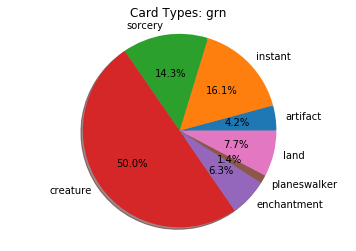

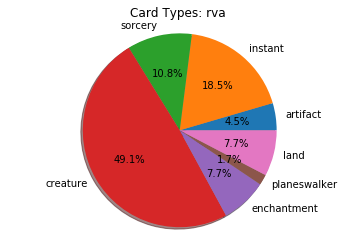

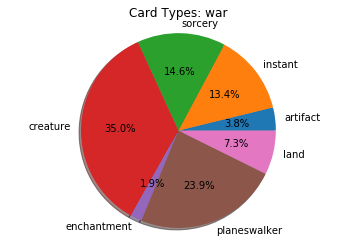

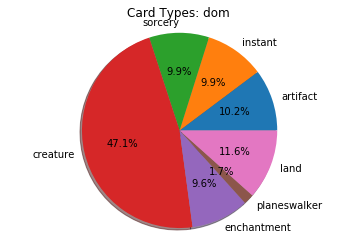

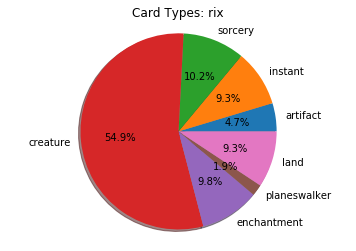

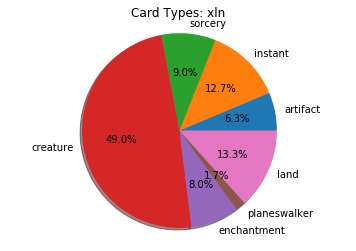

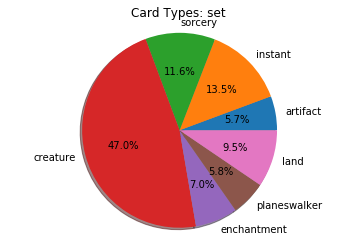

In [11]:
types = ['artifact', 'instant', 'sorcery', 'creature', 'enchantment', 'planeswalker', 'land']

def count_query(count_type):
    q = {
      "query": {
        "match": {
            "types": count_type
        }
      }
    }
    
    return q

def count_set(index):
    counts = []
    for i in range(len(types)):
        counts.append(es.search(index = index, body=count_query(types[i]), size=300)['hits']['total']) 
    return counts

def plot_counts():
    for index in indices:
        sizes = count_set(index)
        fig, ax = plt.subplots()
        ax.pie(sizes,
               labels=types,
               autopct='%1.1f%%',
               shadow=True,
               startangle=0)
        ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
        ax.set_title('Card Types: ' + str(index))


        plt.show()
plot_counts()

### Evaluation

In [12]:
def kappa(data):
    data = np.array(data)
    pAC = 0
    nonRelC = 0
    
    for foo in data:
        if np.count_nonzero(foo) == 2 or np.count_nonzero(foo) == 0:
            pAC += 1
        else:
            nonRelC += 1
            
    rel = (data.sum(axis = 0)[0] + data.sum(axis = 0)[1])/(2 * len(data))
    nonRel = (2* nonRelC)/(2 * len(data))
    pA = pAC/len(data)
    pE = rel**2 + nonRel**2
    kappa = (pA - pE)/(1 - pE)
    
    return kappa

def precisionAt10(groundT, result):
    k = 0
    for x in range(10):
        if groundT[x] == result[x]:
            k += 1
    return k/sum(groundT)

### 1
    <topic number="1"  >
         <query>Flying creature in RVA</query>
         <description>
              Im looking for information on Flying creatures in RVA
         </description>
     </topic>

 Used simple search to evaluate the query <br />
 User 1: [R, N, R, R, R, N , R, R, N , R] <br />
 User 2: [R, N, R, R, N, R , N, R, R , R]

print(kappa(np.array([[1,1],[0,0],[1,1],[1,1],[1,0],[0,1],[1,0],[1,1],[0,1],[1,1]]))) <br />

 Kappa of this simple query is -0.143 meaning the judges disagree, Were solving this by using the advanced
 search to make sure all users get the right documents.

### 2
     <topic number="2"  >
         <query>Red cheap creatures</query>
         <description>
              user 1: Im looking for red cheap creatures for a quick deck
         </description>
         <description>
              user 2: Im looking for red cheap creatures for a late game deck
         </description>
     </topic>

 Used advanced search to evaluate the query <br />
 User 1: [R, N, R, R, R, N , R, R, N , R] <br />
 User 2: [R, N, R, R, R, R , N, R, R , R]

 print(kappa(np.array([[1,1],[0,0],[1,1],[1,1],[1,1],[0,1],[1,1],[1,1],[0,1],[1,1]]))) <br />
 Kappa of this advanced query is 0.375, acceptable but not the best. The complex nature of the tactical 
 needs of users is hard to capture in IR.

### 3
     <topic number="3"  >
         <query>Black mid-cost creatures</query>
         <description>
              Im looking for black sorceries for the mid game
         </description>
     </topic>

 Used advanced search to evaluate the query <br />
 User 1: [R, R, R, R, R, N , N, R, N , R] <br />
 User 2: [R, R, R, R, N, R , N, R, N , R]


 print(kappa(np.array([[1,1],[1,1],[1,1],[1,1],[1,0],[0,1],[0,0],[1,1],[0,0],[1,1]]))) <br />
 Kappa of this advanced query is 0.574, pretty good. 

### 4

     <topic number="4"  >
         <query>Creatures with trample in the collection</query>
         <description>
             Im looking for creatures with trample
         </description>
     </topic>

 Used simple search to evaluate the query <br />
 User 1: [R, R, N, R, R, R , N, N, N , R] <br />
 User 2: [R, R, N, R, N, R , N, N, N , R]


print(kappa(np.array([[1,1],[1,1],[0,0],[1,1],[1,0],[1,1],[0,0],[0,0],[0,0],[1,1]]))) <br />
 Kappa of this simple query is 0.855, good. The simple query seems sufficient in providing
 users with the needed documents. Recall seems lower then the other queries.

### 5

     <topic number="5"  >
         <query>White enchantments for the late game</query>
         <description>
            Im looking for white enchantments to use in the later stages of the game
         </description>
     </topic>

 Used advanced search to evaluate the query <br />
 User 1: [R, R, R, R, R, R , N, N, N , N] <br />
 User 2: [R, R, R, R, R, N , N, N, N , N]


print(kappa(np.array([[1,1],[1,1],[1,1],[1,1],[1,1],[1,0],[0,0],[0,0],[0,0],[0,0]]))) <br />
 Kappa of this simple query is 0.855, good. The advanced query seems to do the job,
 gets all the relevant documents to the top of the results.
 
 
### P@10

1: 0.7 and 0.7 <br />
2: 0.7 and 0.8 <br />
3: 0.7 and 0.7 <br />
4: 0.6 and 0.5 <br />
5: 0.6 and 0.5 <br />

making the avg p@10: 0.65

### WordCloud
Here are the wordclouds for each set. You can see per set what keywords are more important. In the war set the planeswalker is a lot bigger compared to other sets. For the most part these worclouds display more or less the same words. So you can see slight differences, but not too much. 

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)
    
def show_wordcloud_tfidf(data, stop_words, title = None):
    for w in stop_words:
        if w in data:
            del data[w]
    
    wordcloud = WordCloud(
        background_color='white',
        max_words=50,
        max_font_size=40, 
        scale=3,
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [14]:
def tf_idf(index):
    tfidf_dict = {}

    for i in range(es.count(index=index)['count']):
        # Voor elk document in index bekijk term statistics. 
        res = es.termvectors(index=index, doc_type=TYPE, id=str(i), fields=['text'], term_statistics=True)
        
        # aantal worden in document
        l = len(res['term_vectors']['text']['terms'])
        
        for term in res['term_vectors']['text']['terms']:
            # Voor elke term in document bepaal tf-idf score, als deze al in tfidf_dict zit tel de score
            # erbij op, wordt later gemiddelde uit bepaald
            
            df = res['term_vectors']['text']['terms'][term]['doc_freq']    # Document freq van term
            ttf = res['term_vectors']['text']['terms'][term]['ttf']        # Frequency of term over alle documenten
            tfidf = (ttf/l) * np.log2(es.count(index=index)['count'] / df) # tfidf = tf / log2(N/df)
            
            if term not in tfidf_dict:
                tfidf_dict[term] = [tfidf] # Create new entry in dict
            else:
                tfidf_dict[term].append(tfidf) # Add to existing entry
                
    # Calculate average tf-idf for all terms
    for item in tfidf_dict:
        t = tfidf_dict[item]
        tfidf_dict[item] = sum(t)/len(t)        
        
    return tfidf_dict

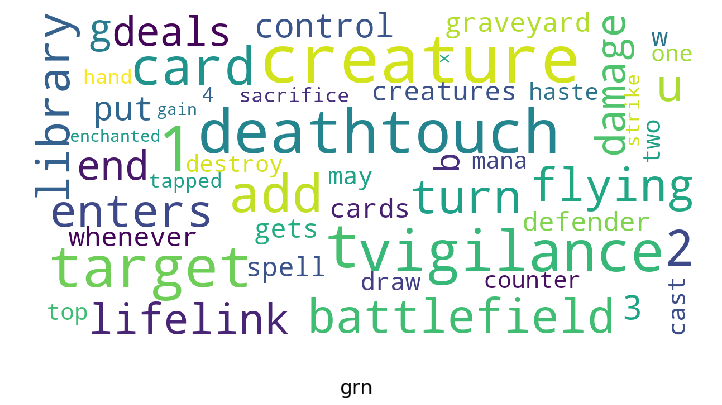

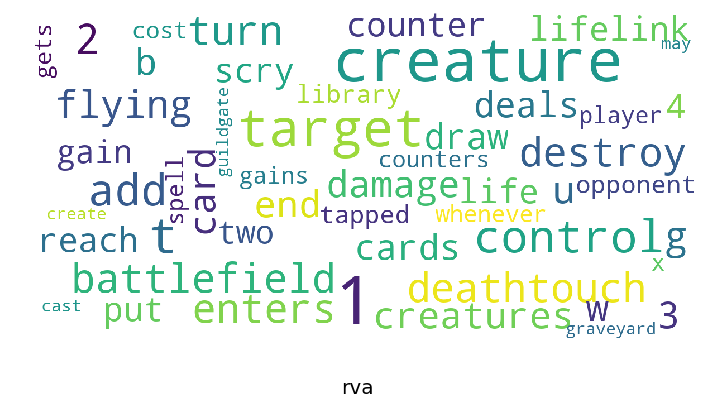

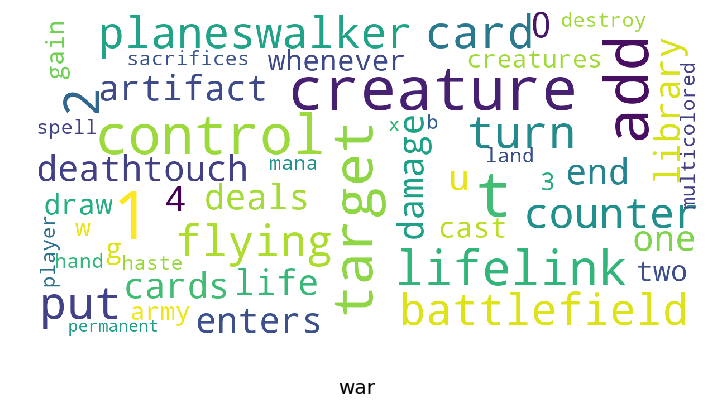

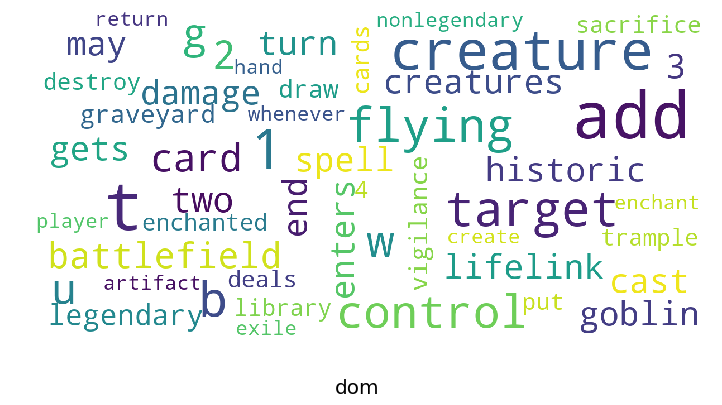

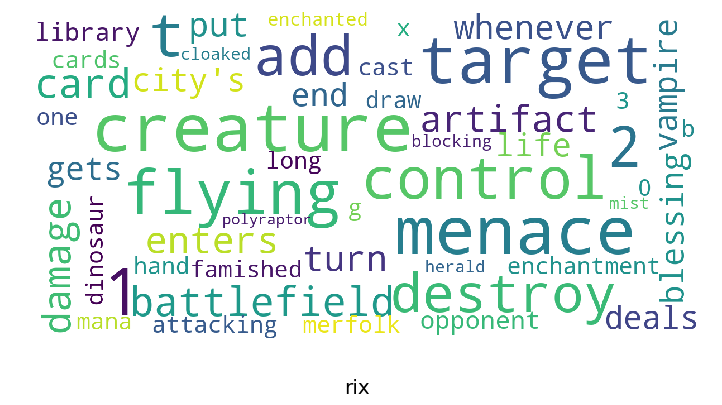

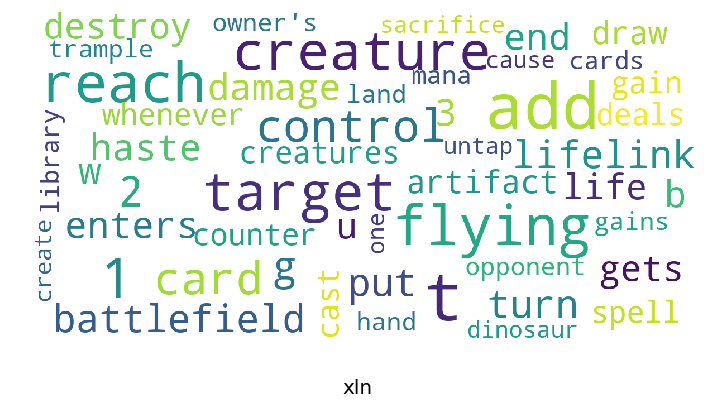

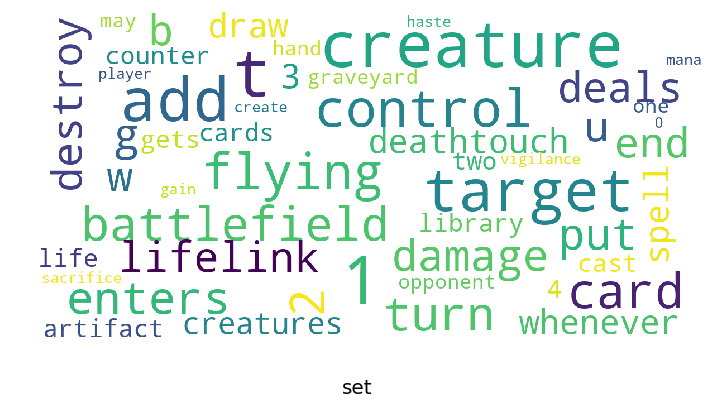

In [15]:
# Wordclouds per set
for i in indices:
    show_wordcloud_tfidf(tf_idf(i), stopwords, title=i)